In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import xml.etree.ElementTree as ET
from IPython.display import clear_output
import tensorflow as tf

!pip install nltk
import nltk
nltk.download('punkt')
clear_output()

if not os.path.exists("articles/"):
  !wget https://zenodo.org/record/1239675/files/articles.zip?download=1 -O articles.zip
  !unzip articles.zip
  !rm articles.zip
  clear_output()
  print("Data successfully downloaded")
else:
  print("Data already downloaded")


random_seed = 176249

Data successfully downloaded


# Clasificación de Orientaciones políticas

En este notebook vamos a tratar de predecir la orientación política del autor de una nota periodística a partir del texto de dicha nota.


El primer paso para ello es leer los datos. En este caso, se tiene un *data frame* con artículos de diarios y la anotación de la orientación política (*left*, *right* o *mainstream*).

In [ ]:
def read_data(test_size=0.2,random_state=0):
  data = {
      # "author": [],
      # "title": [],
      "mainText": [],
      "orientation": [],
      # "veracity": []
  }
  index = []
  for filename in os.listdir("articles/"):
    root = ET.parse(f"articles/{filename}").getroot()
    index.append(int(filename.split(".")[0]))
    for elem in root:
      if elem.tag in data.keys():
        data[elem.tag].append(elem.text)
  data = pd.DataFrame(data,index=index)
  data = data[data.notna().all(axis="columns")]
  data = data.sample(frac=1,random_state=random_state)
  N = len(data)
  train_split, test_split = data.iloc[int(N*test_size):,:], data.iloc[:int(N*test_size),:]
  train_split = train_split.reset_index(drop=True)
  test_split = test_split.reset_index(drop=True)
  return train_split, test_split
  
train_split, test_split = read_data(test_size=0.2,random_state=random_seed)
train_split

,mainText,orientation
0,"Roy Istvan, Cornell Football’s offensive line ...",right
1,A group of Senate Democrats have asked the U.S...,mainstream
2,"Raleigh, North Carolina (CNN)As soon as the fi...",mainstream
3,"On Friday morning, Donald Trump released addit...",right
4,Donald Trump’s efforts to attract any kind of ...,left
...,...,...
1279,Chuck Schumer is sitting on a mountain of cash...,mainstream
1280,In discussing shootings and crime in the first...,left
1281,At least 858 people who had previously been or...,mainstream
1282,When you WATCH this VIDEO you MUST have tissue...,right


Una práctica muy común para procesar texto es normalizarlo. Algunas técnicas comunes son:
* Eliminar caracteres raros e inusuales
* Convertir todo a minúsculas
* Eliminar palabras que no contienen información relevante (*stop words*)
* *Lemmatization*
* *Stemming*

In [ ]:
def normalize_text(corpus,stop_words=None):

  # Convierto a lowercase
  corpus_lower = corpus.str.lower()

  # Elimino signos de puntuación, caracteres raros, etc.
  normalized_corpus = corpus_lower.str.replace(r"[^\w\d\s]+","",regex=True)

  # Elimino los stopwords
  if stop_words is not None:
    stop_words = "|".join(stop_words)
    normalized_corpus = normalized_corpus.str.replace(stop_words,"",regex=True)

  # Elimino espacios innecesarios
  normalized_corpus = normalized_corpus.str.replace(r"\s+"," ",regex=True)

  return normalized_corpus

train_data, test_data = read_data(test_size=0.2,random_state=random_seed)
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=None)
train_data

,mainText,orientation
0,roy istvan cornell footballs offensive line co...,right
1,a group of senate democrats have asked the us ...,mainstream
2,raleigh north carolina cnnas soon as the first...,mainstream
3,on friday morning donald trump released additi...,right
4,donald trumps efforts to attract any kind of s...,left
...,...,...
1279,chuck schumer is sitting on a mountain of cash...,mainstream
1280,in discussing shootings and crime in the first...,left
1281,at least 858 people who had previously been or...,mainstream
1282,when you watch this video you must have tissue...,right


Una vez preprocesado, es necesario definir el vocabulario. Es decir, el conjunto de palabras que van a ser consideradas en la extracción de *features*.

100%|██████████| 1284/1284 [00:03<00:00, 377.73it/s]


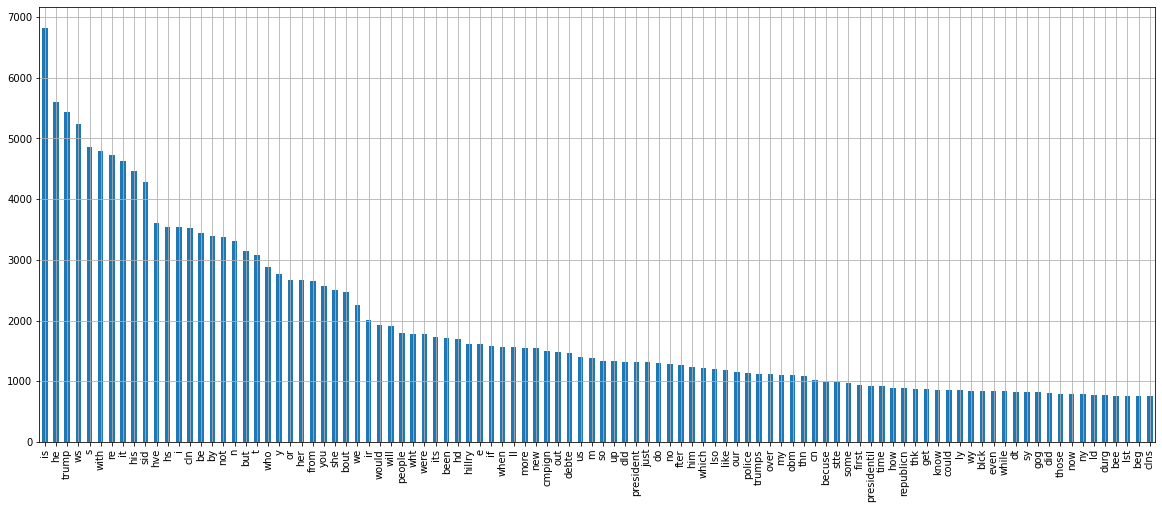

In [ ]:
from nltk import word_tokenize
from collections import defaultdict

def create_vocabulary(corpus,tokenizer,max_tokens=40000,min_freq=1):
  counts = defaultdict(lambda: 0)
  for comment in tqdm(corpus):
    for token in tokenizer(comment):
      counts[token] += 1

  valid_tokens = sorted([tk for tk in counts.keys() if counts[tk] >= min_freq],key=counts.get,reverse=True)[:max_tokens]
  counts = [counts[tk] for tk in valid_tokens]
  return pd.Series(counts,index=valid_tokens)

train_data, test_data = read_data()
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on"])
vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=10000,min_freq=5)

fig, ax = plt.subplots(1,1,figsize=(20,8))
vocab[:100].plot(kind="bar",ax=ax,fontsize=10)
ax.grid(True)

Una vez hecho esto, es posible vectorizar cada noticia haciendo lo que se conoce como una "bolsa de palabras" (*bag of words*). Es decir, cada documento (noticia) de la base de datos va a consistir en un vecor que contenga en sus componentes la cantidad de veces que aparecieron las palabras del vocabulario en él. 

In [ ]:
def vectorize(corpus,tokenizer,vocab):
  N = len(vocab)
  corpus_size = len(corpus)
  X = np.zeros((len(corpus),N))

  token2idx = {tk: i for i, tk in enumerate(vocab.index)}
  for i, article in enumerate(tqdm(corpus)):
    for w in tokenizer(article):
      if w in vocab.index:
        idx = token2idx[w]
        X[i,idx] += 1
  
  return X
        
train_data, test_data = read_data()
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on"])
test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on"])

vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=10000,min_freq=5)
X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

100%|██████████| 320/320 [00:00<00:00, 615.80it/s]


## Baseline

*Show time!* Ahora sí vamos a clasificar noticias. Cuando tenemos una base de datos nueva, una buena práctica es utilizar un modelo ingénuo (*dummy* o *naive*) para evaluarlo. En clasificación es muy común utilizar un modelo que aprende cuál fue la clase más frecuente durante el entrenamiento y elige siempre ésta cuando tiene que realizar una predicción. Esto puede implementarse fácilmente utilizando el objeto `DummyClassifier` de [scikit-learn](https://scikit-learn.org/stable/index.html).

Para evaluar nuestro clasificación vamos a utilizar algunas funciones de la librería `metrics` del mismo paquete. En particular, `plot_confusion_matrix` nos muestra la matriz de confusión del problema de clasificación.

Baseline model:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       173
           1       0.00      0.00      0.00        90
           2       0.00      0.00      0.00        57

    accuracy                           0.54       320
   macro avg       0.18      0.33      0.23       320
weighted avg       0.29      0.54      0.38       320



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


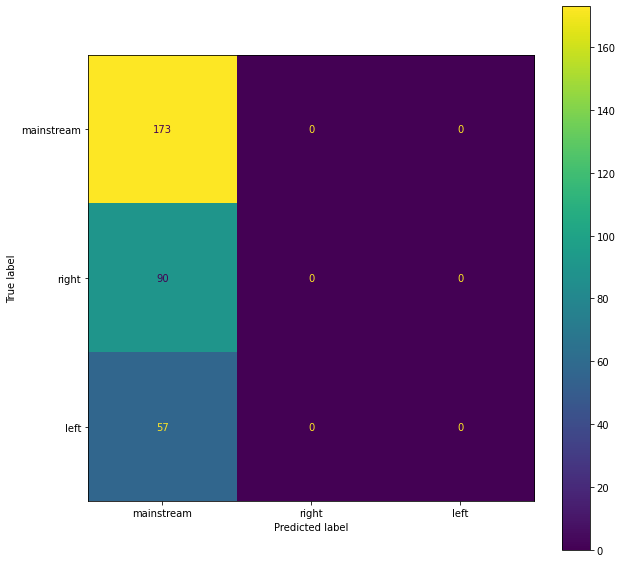

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

def show_results(y_true,y_pred):

  # Plot confusion matrix
  fig, ax = plt.subplots(1,1,figsize=(10,10))
  dsp = ConfusionMatrixDisplay.from_predictions(y_true,y_pred,display_labels=["mainstream", "right", "left"],ax=ax)

  # Show Classification report
  print(classification_report(y_true,y_pred))


clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_train,y_train)
y_test_pred = clf.predict(X_test)
print("Baseline model:")
show_results(y_test,y_test_pred)

## BOW + Clasificador Softmax

**Tarea 1: Implementar una vectorización por bolsa de palabras y entrenar un clasificador Softmax para clasificar orientaciones políticas. Utilizar exactitud como métrica de evaluación.**

Analizar:
* ¿Funciona mejor el clasificador entrenado que el modelo baseline?
* ¿Cómo influye la cantidad de palabras elegidas? ¿Y la frecuencia mínima de aparición? 
* ¿Qué importancia tienen las stop words en este caso?
* ¿Hay overfitting? ¿Cómo podría reducirlo?

In [ ]:
vocab[vocab.index.isin(['trump'])]

trump    5436
dtype: int64

In [ ]:
def get_and_bow_vectorize_data(
    stop_words=None,
    max_tokens=10000,
    min_freq=1
):

  train_data, test_data = read_data()
  train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=stop_words)
  test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=stop_words)

  vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=max_tokens,min_freq=min_freq)
  X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
  y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
  y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  return X_train, y_train, X_test, y_test

# Leo y vectorizo las noticias
X_train, y_train, X_test, y_test = get_and_bow_vectorize_data()

# TODO: Implementar Softmax Classifier
def softmax(x):
    
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x



# END TODO

100%|██████████| 320/320 [00:01<00:00, 284.30it/s]


In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(3, input_dim=10000, activation = 'softmax'))
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0022),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])
hist = model.fit(x=X_train, y=y_train, batch_size = 1284, epochs=500,callbacks=[es])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 0s 270ms/step - loss: 1.3479 - accuracy: 0.3380
Epoch 2/500
1/1 [==============================] - 0s 32ms/step - loss: 1.3420 - accuracy: 0.5062
Epoch 3/500
1/1 [==============================] - 0s 60ms/step - loss: 0.9967 - accuracy: 0.5039
Epoch 4/500
1/1 [==============================] - 0s 47ms/step - loss: 0.9738 - accuracy: 0.5164
Epoch 5/500
1/1 [==============================] - 0s 47ms/step - loss: 0.9634 - accuracy: 0.5265
Epoch 6/500
1/1 [==============================] - 0s 71ms/step - loss: 0.9534 - accuracy: 0.5421
Epoch 7/500
1/1 [==============================] - 0s 41ms/step - loss: 0.9446 - accuracy: 0.5335
Epoch 8/500
1/1 [==============================] - 0s 52ms/step - loss: 0.9358 - accuracy: 0.5561
Epoch 9/500
1/1 [==============================] - 0s 42ms/step - loss: 0.9277 - accuracy: 0.5522
Epoch 10/500
1/1 [==============================] - 0s 58ms/step - loss: 0.9198 - accuracy: 0.5685
Epoch 11/500
1/1 [============

In [ ]:
def predecir_orientacion_politica(x, model):
  return np.argmax(model.predict(x=x), axis = 1)

precision = (np.array(y_test) == predecir_orientacion_politica(X_test, model)).mean()
precision

10/10 [==============================] - 0s 1ms/step


0.80625

Como podemos ver, la accuracy en entrenamiento y luego de testear es un poco distinta lo cual nos puede estar hablando de un overfitting. Podría agregar un early stopping al modelo para evitarlo o disminuir los epochs.

10/10 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       173
           1       0.71      0.86      0.77        90
           2       0.85      0.39      0.53        57

    accuracy                           0.81       320
   macro avg       0.80      0.72      0.73       320
weighted avg       0.81      0.81      0.79       320



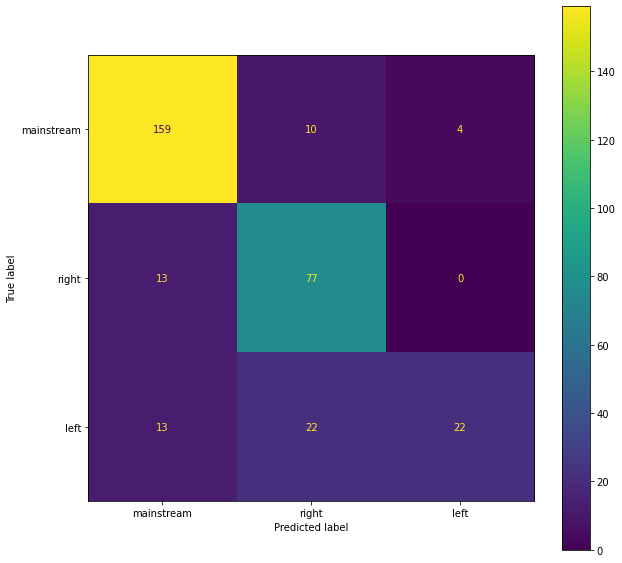

In [ ]:
show_results(y_test,predecir_orientacion_politica(X_test, model))

## Features selection

**Tarea 2: Implementar una vectorización por palabras claves. Es decir, definir un vocabulario inspeccionando las noticias de la base de datos y tratar de hipotetizar qué palabras pueden servir para discriminar entre noticias de izquierda, derecha y *mainstream*. Una  vez hecho esto, implementar nuevamente el clasificador anterior y utilizarlo para predecir en este nuevo escenario.**

Hint: para este análisis puede que sea necesario hacer una inspección de los datos y ver qué palabras aparecieron en cada categoría. En este punto, cualquier idea *out-of-the-box* también puede ser útil :)

In [ ]:
def get_data_and_select_keywords(
    stop_words=None,
):

  train_data, test_data = read_data()
  train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=stop_words)
  test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=stop_words)

  # TODO: implementar selección de palabras claves.
  vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=10000,min_freq=5)
  vocab = vocab[vocab.index.isin(['socialist', 'americans', 'corruption', 'republican', 'market', 'poverty', 'healthcare', 'job', 'property', 'rights', 'black', 'supporter', 'opposition', 'radical', 'left', 'right', 'decline', 'racist', "inclusion", 'capitalism'])]
  # END TODO

  X_train = vectorize(train_data["mainText"],word_tokenize, vocab)
  y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  X_test = vectorize(test_data["mainText"],word_tokenize, vocab)
  y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  return X_train, y_train, X_test, y_test

# Leo y vectorizo las noticias
X_train, y_train, X_test, y_test = get_data_and_select_keywords()

# TODO: Implementar Softmax Classifier

# END TODO

100%|██████████| 320/320 [00:00<00:00, 562.68it/s]


In [ ]:
print(y_train.shape)

(1284,)


In [ ]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Dense(3, input_dim=19, activation='softmax'))
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0022),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])
hist = model2.fit(x=X_train, y=y_train, batch_size = 1284, epochs=500,callbacks=[es])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 0s 179ms/step - loss: 1.1898 - accuracy: 0.3746
Epoch 2/500
1/1 [==============================] - 0s 6ms/step - loss: 1.1891 - accuracy: 0.3746
Epoch 3/500
1/1 [==============================] - 0s 6ms/step - loss: 1.1884 - accuracy: 0.3738
Epoch 4/500
1/1 [==============================] - 0s 6ms/step - loss: 1.1878 - accuracy: 0.3738
Epoch 5/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1871 - accuracy: 0.3738
Epoch 6/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1864 - accuracy: 0.3738
Epoch 7/500
1/1 [==============================] - 0s 5ms/step - loss: 1.1857 - accuracy: 0.3738
Epoch 8/500
1/1 [==============================] - 0s 5ms/step - loss: 1.1850 - accuracy: 0.3738
Epoch 9/500
1/1 [==============================] - 0s 5ms/step - loss: 1.1843 - accuracy: 0.3738
Epoch 10/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1836 - accuracy: 0.3746
Epoch 11/500
1/1 [=====================

10/10 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.58      0.77      0.67       173
           1       0.43      0.40      0.41        90
           2       0.17      0.02      0.03        57

    accuracy                           0.53       320
   macro avg       0.39      0.40      0.37       320
weighted avg       0.47      0.53      0.48       320



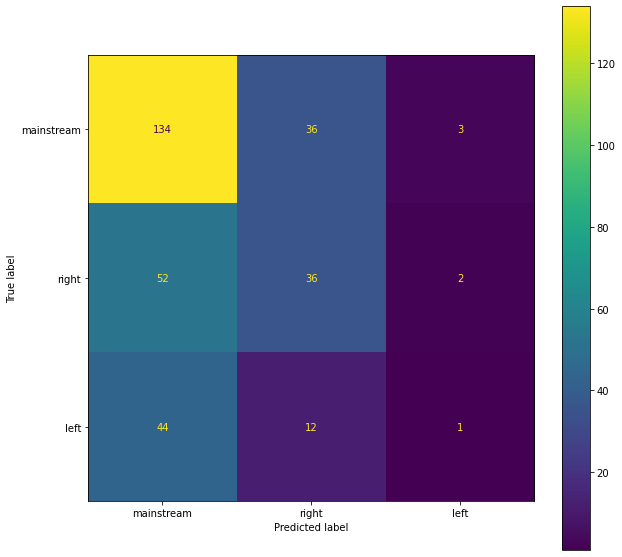

In [ ]:
show_results(y_test,predecir_orientacion_politica(X_test, model2))

Como podemos ver, la clasificación de este nuevo modelo no es tan buena como la del anterior, lo cual debe ser porque el vocabulario elegido no es lo suficientemente representativo.